In [96]:
#Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np     

# MMM Ventas

En este modelo vamos a realizar un modelo de atribucción para las ventas

## Tabla Final

A continuación cargamos todas las tablas que vamos a emplear para el modelo de atribución:

In [57]:
df_web = pd.read_csv("../data/raw/web.csv", sep=",")
df_offline = pd.read_csv("../data/raw/offline.csv", sep=",")
df_time = pd.read_csv("../data/raw/time.csv", sep=",")
df_visit = pd.read_csv("../data/raw/visit.csv", sep=",")
df_inv = pd.read_csv("../data/raw/inv.csv", sep=",")

Tenemos que añadir los sufijos web y offline a las columans de estas tablas ya que sus nombre coinciden y posteriormente al hacer el merge necesitamos distinguirlas.

In [58]:
df_offline = df_offline.rename(columns={
    col: f"{col}_off" for col in df_offline.columns if col != "ID_Date"})


df_visit = df_visit.rename(columns={
    col: f"{col}_visit" for col in df_visit.columns if col != "ID_Date"})


## Tabla Inversión

Se han generado las siguientes métricas a partir de la tabla de inversión mensual(de cara a facilitar la evaluación del budget):

- `Pct_Online`: porcentaje de la inversión total del mes destinada a medios online.
- `Pct_Offline`: porcentaje de la inversión total del mes destinada a medios offline.
- `Pct_Otros`: porcentaje de la inversión total destinada a costes generales no atribuibles directamente a un canal.

In [59]:
# Online
inversion_online = df_inv['INTERNET'] + df_inv['PlataformasVideo']

# Offline
inversion_offline = (
    df_inv['CINE'] + df_inv['EXTERIOR'] + df_inv['PRENSA'] +
    df_inv['RADIO'] + df_inv['REVISTAS']
)

# Otros (costes generales de producción y varios)
otros = df_inv['PRODUCCION'] + df_inv['VARIOS']

df_inv['Pct_Online'] = inversion_online / df_inv['INV_Total']
df_inv['Pct_Offline'] = inversion_offline / df_inv['INV_Total']
df_inv['Pct_Otros'] = otros / df_inv['INV_Total']


In [60]:
df_inv.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Pct_Online,Pct_Offline,Pct_Otros
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,574600.14,0.822296,0.154068,0.023636
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,916515.08,0.738464,0.246619,0.014917
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,367522.47,0.786449,0.161895,0.051656
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,941187.91,0.856028,0.108054,0.035918
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,746390.17,0.702853,0.279962,0.017185


**Merge para Tabla Final**

In [61]:
# Union todas las tablas por PK=ID_date
df_merge = df_inv.merge(df_web, on='ID_Date')
df_merge = df_merge.merge(df_offline, on='ID_Date')
df_merge = df_merge.merge(df_time, on='ID_Date')
df_merge = df_merge.merge(df_visit, on='ID_Date')
df_merge = df_merge.sort_values('ID_Date')

# Calculamos el delay de compras
df_merge['Sales_1_ago'] = df_merge['Sales_off'].shift(1) # 1 mes atras
df_merge['Sales_2_ago'] = df_merge['Sales_off'].shift(2) # 2 meses atras


*Nota*:Para los primeros dos meses deconcoemos los visitantes previos pero los dejamos como NaN para que lo gestione el modelo.

In [62]:
df_merge.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,...,RopaHombre_visit,RopaMujer_visit,Complementos_visit,Zapatos_visit,Home_visit,Interior_visit,Otros_visit,SR_Total_visit,Sales_1_ago,Sales_2_ago
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,...,50140,81289,16190,36790,18848,9906,183,213346,NaN,NaN
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,...,51217,152805,26083,37960,20047,11057,461,299630,1299.0,NaN
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,...,49163,68383,18109,37765,20105,66200,198,259923,1752.0,1299.0
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,...,48219,65126,16985,76244,17629,17827,176,242206,1897.0,1752.0
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,...,42229,44577,16498,79434,18526,10738,186,212188,1546.0,1897.0


## Correlaciones con Sales

### Tabla Time

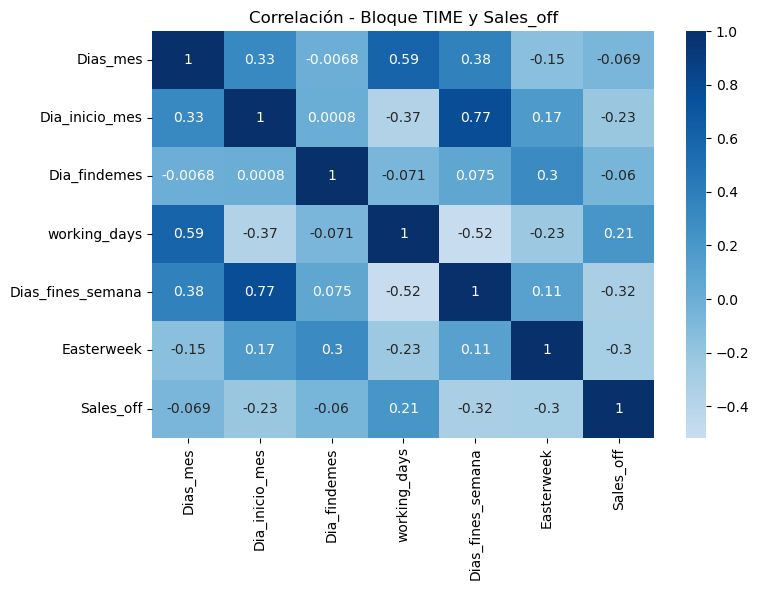

In [63]:
cols_time = ['Dias_mes', 'Dia_inicio_mes', 'Dia_findemes', 'working_days', 'Dias_fines_semana', 'Easterweek', 'Sales_off']

df_time_corr = df_merge[cols_time]
corr_time = df_time_corr.corr(numeric_only=True)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_time, annot=True, cmap='Blues', center=0)
plt.title("Correlación - Bloque TIME y Sales_off")
plt.tight_layout()
plt.show()


**Variables Más Correlacionadas en Time con Sales**

In [64]:
df_merge.groupby('Easterweek')['Sales_off'].mean()


Easterweek
0    1762.272727
1    1451.333333
Name: Sales_off, dtype: float64

In [65]:
df_merge.groupby('Dias_fines_semana')['Sales_off'].mean()

Dias_fines_semana
8     1812.526316
9     1715.666667
10    1578.750000
Name: Sales_off, dtype: float64

Finalmente las varibales que más influyen sobre las ventas son:

| Variable            |  Sales_off | Sentido de la relación                            |
|---------------------|------------------------------|----------------------------------------------------|
| Dias_fines_semana | **–0.32**                   | A más fines de semana, menos ventas                |
| Easterweek        | **–0.30**                   | Semana Santa reduce ventas                         |
| working_days      | **+0.21**                   | A más días laborables, más ventas                  |



### Tabla Inv

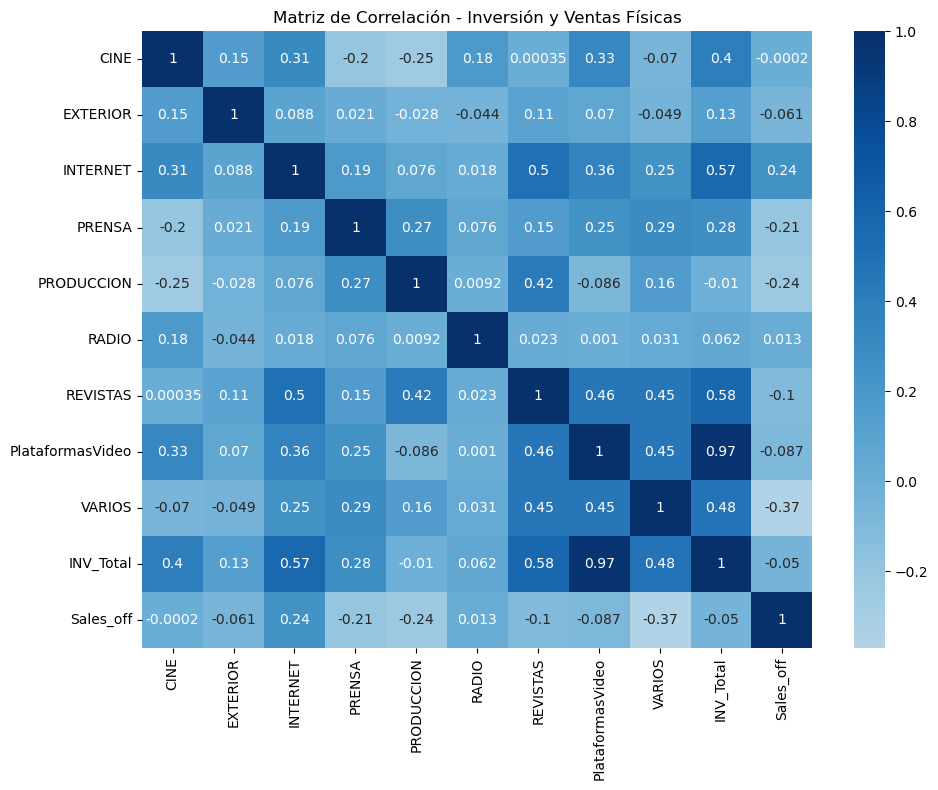

In [68]:
cols_inv = [
    'CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION',
    'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS',
    'INV_Total', 'Sales_off'
]


df_inv_corr = df_merge[cols_inv]
corr_inv = df_inv_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_inv, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Inversión y Ventas Físicas")
plt.tight_layout()
plt.show()

**Variables de INV más correlacionadas con Sales**

Aunque incialmente agrupamos la inversión en medios offline y online, hemos decicido analizar más fondo la relación de la publidad en cada medio con las ventas


 Variables con correlación **positiva** 

| Variable   | Correlación | Interpretación breve                            |
|------------|-------------|--------------------------------------------------|
| INTERNET | +0.24 | Invertir en internet se asocia a más ventas                  |

 Variables con correlación **negativa**

| Variable     | Correlación | Interpretación breve                               |
|--------------|-------------|-----------------------------------------------------|
| VARIOS     | –0.37  | Inversión en canales diversos resta a las ventas   |
| PRODUCCION | –0.24  | Posible coste sin retorno inmediato                |
|PRENSA     |–0.21   | Canales tradicionales podrían tener menor impacto  |



### Tabla Web

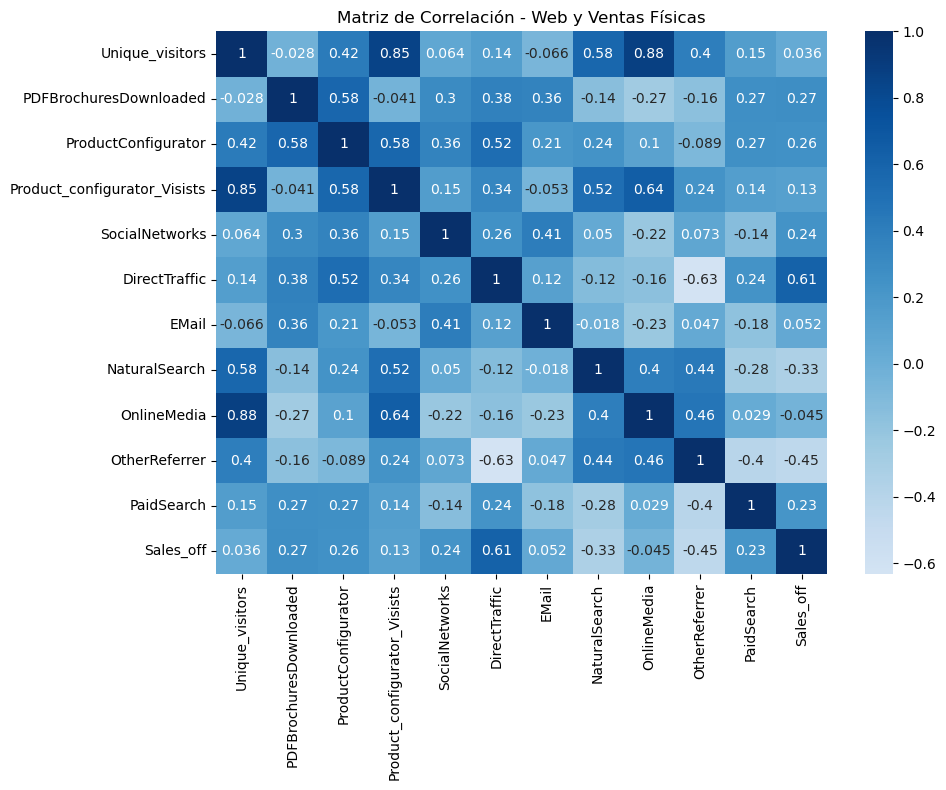

In [ ]:

# Columnas del bloque WEB y ventas físicas
cols_web = [
    'Unique_visitors', 'PDFBrochuresDownloaded', 'ProductConfigurator',
    'Product_configurator_Visists', 'SocialNetworks', 'DirectTraffic',
    'EMail', 'NaturalSearch', 'OnlineMedia', 'OtherReferrer', 'PaidSearch',
    'Sales_off'
]


df_web_corr = df_merge[cols_web]
corr_web = df_web_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_web, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Web y Ventas Físicas")
plt.tight_layout()
plt.show()



**Variables más correlacionados con Sales**

Variables con correlación **positiva**

| Variable                  | Correlación | Significado                                                         |
|---------------------------|-------------|---------------------------------------------------------------------|
| DirectTraffic            | +0.61       | Usuarios que acceden directamente al sitio web. Alta intención de compra y conversión. |
| PDFBrochuresDownloaded   | +0.27       | Descarga de catálogos = mayor interés en los productos.            |
| ProductConfigurator     | +0.26       | Uso del configurador de productos = intención clara de compra.     |
| SocialNetwork         | +0.24       | Tráfico proveniente de redes sociales, aumenat ventas. |

Variables con correlación **negativa**

| Variable                  | Correlación | Significado                                                         |
|---------------------------|-------------|---------------------------------------------------------------------|
| OtherReferrer            | –0.45       | Tráfico proveniente de webs externas, sin intención clara de compra.|
| NaturalSearch          | –0.33       | Resutados que que sugiere directamente el navegador|



### Tabla Visit

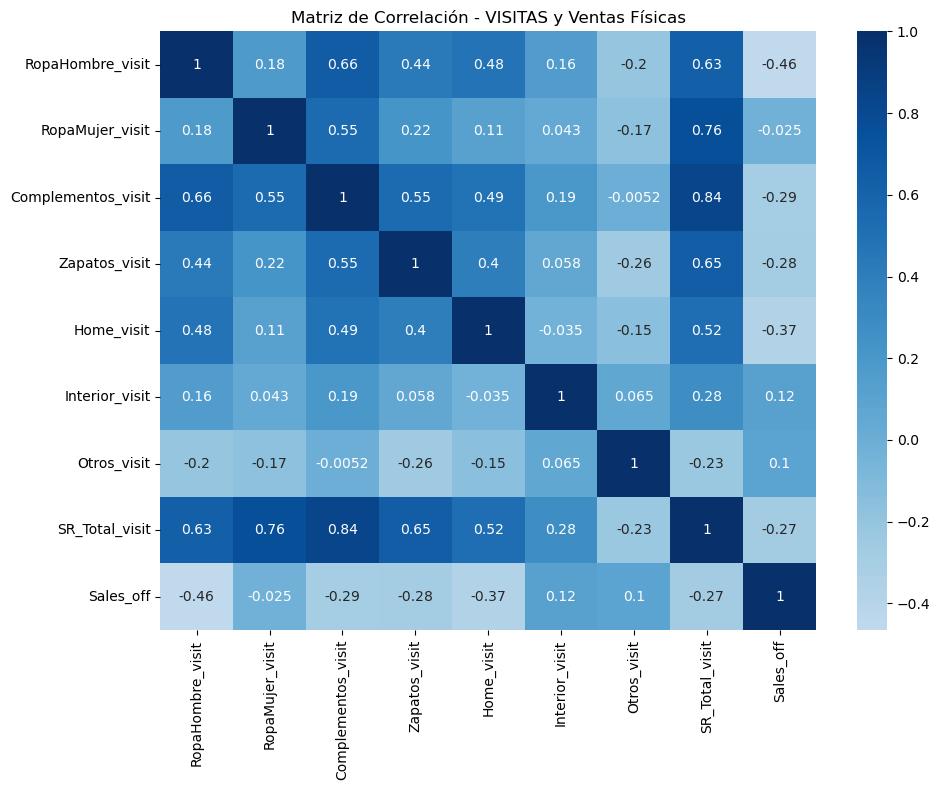

In [71]:
cols_visit = [
    'RopaHombre_visit', 'RopaMujer_visit', 'Complementos_visit', 
    'Zapatos_visit', 'Home_visit', 'Interior_visit', 'Otros_visit', 
    'SR_Total_visit', 'Sales_off'
]


df_visit_corr = df_merge[cols_visit]


corr_visit = df_visit_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_visit, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - VISITAS y Ventas Físicas")
plt.tight_layout()
plt.show()


### Tabla Offline

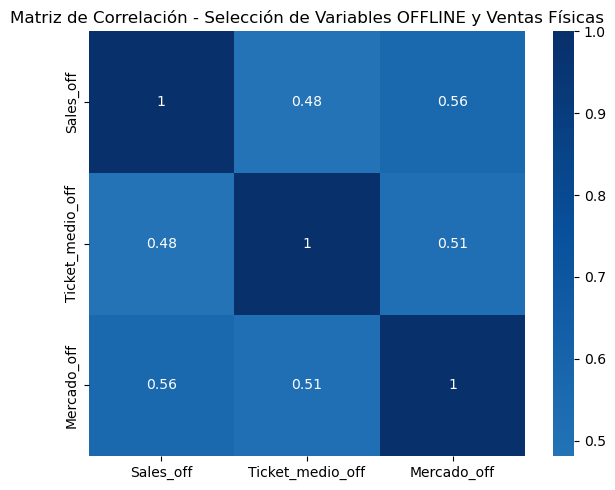

In [ ]:

cols_selected = ['Sales_off', 'Ticket_medio_off', 'Mercado_off']

df_selected_corr = df_merge[cols_selected]
corr_selected = df_selected_corr.corr(numeric_only=True)

# Generar el heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_selected, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Selección de Variables OFFLINE y Ventas Físicas")
plt.tight_layout()
plt.show()


## Regresión Ventas

In [ ]:

df_merge['Sales_1_ago'] = df_merge['Sales_1_ago'].bfill()  # o fillna(0)
df_merge['Sales_2_ago'] = df_merge['Sales_2_ago'].bfill()

variables_modelo = [
    'Sales_1_ago','Sales_2_ago', #Delay
    'Pct_Online', 'Pct_Offline', 'Pct_Otros', #Porcentajes de Presupuesto
    
    'working_days', 'Dias_fines_semana','Dia_inicio_mes', # Variables Exógenas vistas web
    'DirectTraffic', 'PDFBrochuresDownloaded', 'ProductConfigurator',
    'SocialNetworks', 'OtherReferrer', 'NaturalSearch','PaidSearch',
    'Mercado_off', 'Ticket_medio_off' # Ticket promedio y diferencia de Mercado en tienda
]

# Definir X e y
X = df_merge[variables_modelo]
y = df_merge['Sales_off']

# Ajustar modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Predicciones
y_pred = modelo.predict(X)

# Métricas
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

r2, mae, rmse


(0.8191127745482583, 99.68175535124666, 123.1852293523211)